# Silhouette Score: Evaluando la Calidad de tus Clusters

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


# Configuración general
np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== ANÁLISIS DE CLUSTERING CON SILHOUETTE SCORE ===\n")


=== ANÁLISIS DE CLUSTERING CON SILHOUETTE SCORE ===



In [28]:
# Generar datos con 4 grupos bien definidos
X, y_true = make_blobs(
    n_samples=300,
    centers=4,
    cluster_std=0.8,
    center_box=(-10.0, 10.0),
    random_state=42
)

print(f"Forma del dataset: {X.shape}")
print("Datos generados con 4 centros.")


Forma del dataset: (300, 2)
Datos generados con 4 centros.


In [30]:
def find_optimal_clusters(X, max_k=10):
    """Evalúa el Silhouette Score para diferentes valores de k."""
    silhouette_scores = []
    K_range = range(2, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"k={k}: Silhouette Score = {silhouette_avg:.4f}")
    
    return K_range, silhouette_scores


In [32]:
print("=== BÚSQUEDA DEL NÚMERO ÓPTIMO DE CLUSTERS ===")
k_range, scores = find_optimal_clusters(X, max_k=8)

optimal_k = k_range[np.argmax(scores)]
optimal_score = max(scores)

print(f"\nNúmero óptimo de clusters: k={optimal_k}")
print(f"Silhouette Score óptimo: {optimal_score:.4f}")


=== BÚSQUEDA DEL NÚMERO ÓPTIMO DE CLUSTERS ===
k=2: Silhouette Score = 0.6030
k=3: Silhouette Score = 0.7783
k=4: Silhouette Score = 0.8335
k=5: Silhouette Score = 0.6976
k=6: Silhouette Score = 0.5882
k=7: Silhouette Score = 0.4487
k=8: Silhouette Score = 0.3322

Número óptimo de clusters: k=4
Silhouette Score óptimo: 0.8335


In [34]:
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels_optimal = kmeans_optimal.fit_predict(X)

# Calcular valores de silueta por muestra
sample_silhouette_values = silhouette_samples(X, cluster_labels_optimal)


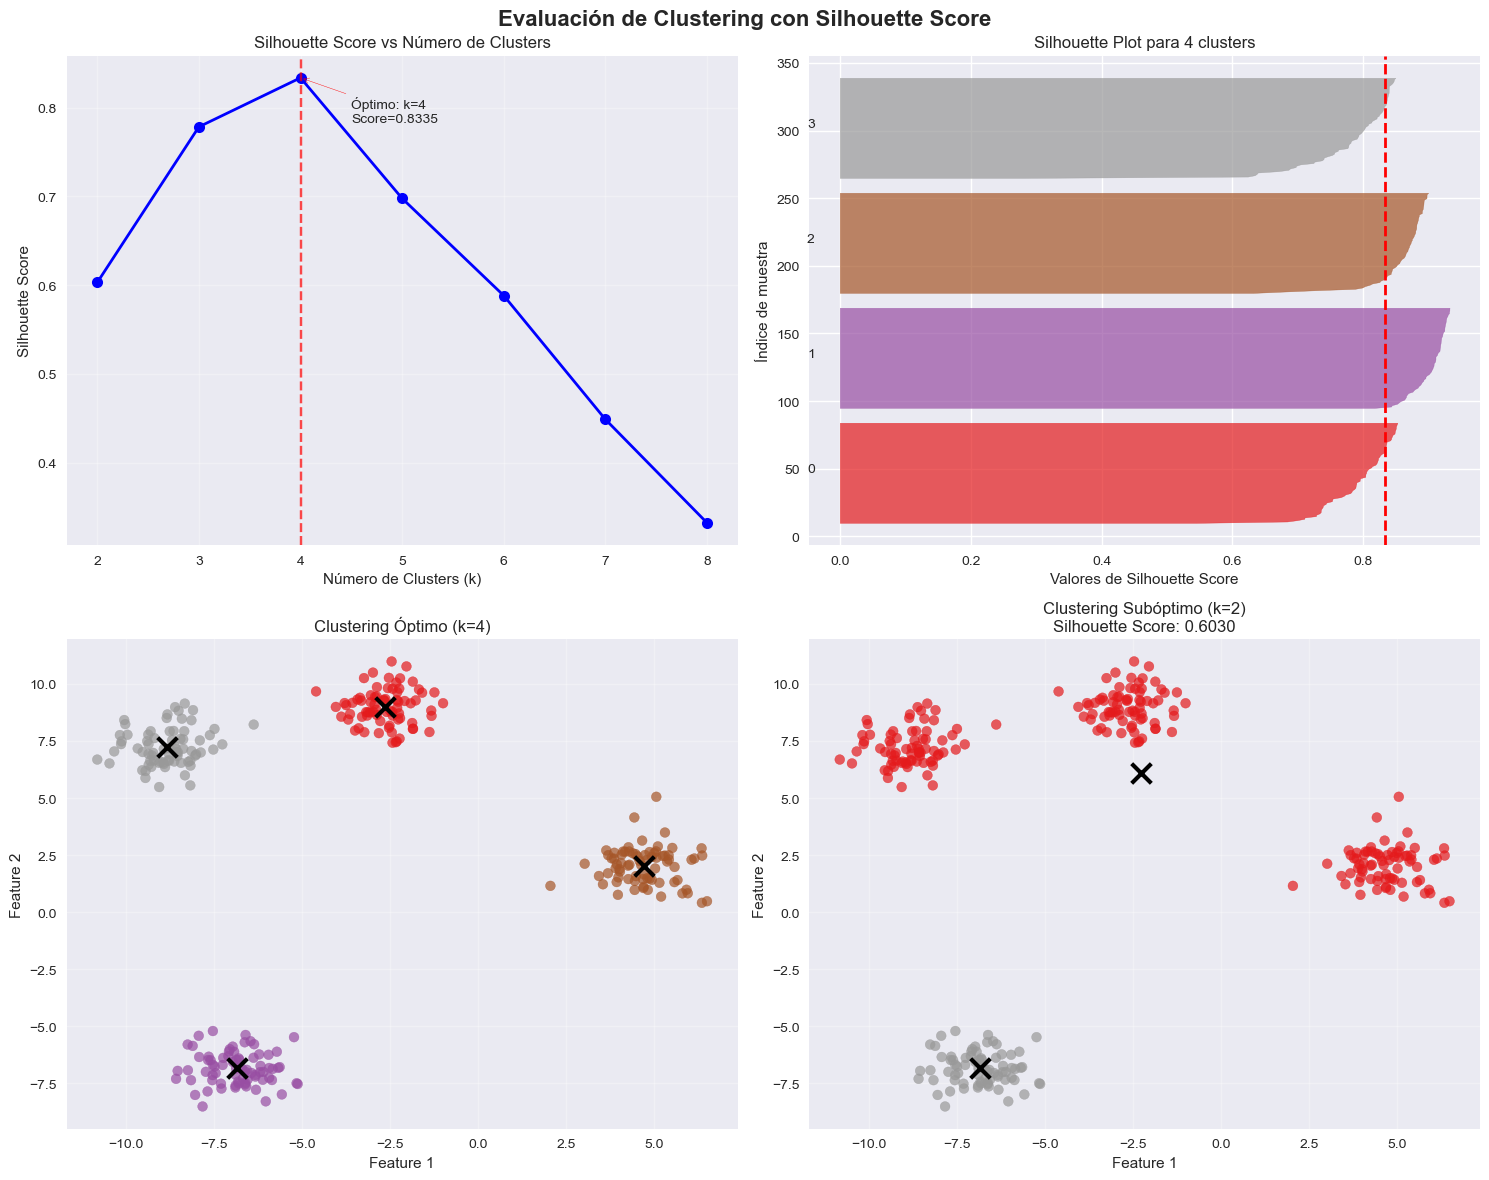

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Evaluación de Clustering con Silhouette Score', fontsize=16, fontweight='bold')

# --- Gráfico 1: Silhouette Score vs k ---
ax1.plot(k_range, scores, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7)
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score vs Número de Clusters')
ax1.grid(True, alpha=0.3)
ax1.annotate(f'Óptimo: k={optimal_k}\nScore={optimal_score:.4f}',
             xy=(optimal_k, optimal_score),
             xytext=(optimal_k + 0.5, optimal_score - 0.05),
             arrowprops=dict(arrowstyle='->', color='red'))

# --- Gráfico 2: Silhouette Plot (detalle por muestra) ---
y_lower = 10
colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    cluster_silhouette_values = sample_silhouette_values[cluster_labels_optimal == i]
    cluster_silhouette_values.sort()
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax2.axvline(x=optimal_score, color="red", linestyle="--", linewidth=2)
ax2.set_xlabel('Valores de Silhouette Score')
ax2.set_ylabel('Índice de muestra')
ax2.set_title(f'Silhouette Plot para {optimal_k} clusters')

# --- Gráfico 3: Clustering óptimo ---
scatter = ax3.scatter(X[:, 0], X[:, 1], c=cluster_labels_optimal,
                      cmap='Set1', alpha=0.7, s=50)
centers = kmeans_optimal.cluster_centers_
ax3.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=200, linewidths=3)
ax3.set_xlabel('Feature 1')
ax3.set_ylabel('Feature 2')
ax3.set_title(f'Clustering Óptimo (k={optimal_k})')
ax3.grid(True, alpha=0.3)

# --- Gráfico 4: Comparación con clustering subóptimo (k=2) ---
kmeans_suboptimal = KMeans(n_clusters=2, random_state=42)
cluster_labels_suboptimal = kmeans_suboptimal.fit_predict(X)
suboptimal_score = silhouette_score(X, cluster_labels_suboptimal)

ax4.scatter(X[:, 0], X[:, 1], c=cluster_labels_suboptimal, cmap='Set1', alpha=0.7, s=50)
centers_sub = kmeans_suboptimal.cluster_centers_
ax4.scatter(centers_sub[:, 0], centers_sub[:, 1], c='black', marker='x', s=200, linewidths=3)
ax4.set_xlabel('Feature 1')
ax4.set_ylabel('Feature 2')
ax4.set_title(f'Clustering Subóptimo (k=2)\nSilhouette Score: {suboptimal_score:.4f}')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [38]:
print("\n=== ANÁLISIS DETALLADO POR CLUSTER ===")
for i in range(optimal_k):
    cluster_mask = cluster_labels_optimal == i
    cluster_silhouette_values = sample_silhouette_values[cluster_mask]
    
    print(f"Cluster {i}:")
    print(f"  Tamaño: {np.sum(cluster_mask)} puntos")
    print(f"  Silhouette promedio: {np.mean(cluster_silhouette_values):.4f}")
    print(f"  Desviación estándar: {np.std(cluster_silhouette_values):.4f}")
    print(f"  Rango: [{np.min(cluster_silhouette_values):.4f}, {np.max(cluster_silhouette_values):.4f}]")
    
    negative_points = np.sum(cluster_silhouette_values < 0)
    if negative_points > 0:
        print(f"    Puntos problemáticos: {negative_points} ({negative_points/len(cluster_silhouette_values)*100:.1f}%)")
    print()



=== ANÁLISIS DETALLADO POR CLUSTER ===
Cluster 0:
  Tamaño: 75 puntos
  Silhouette promedio: 0.7930
  Desviación estándar: 0.0524
  Rango: [0.5445, 0.8518]

Cluster 1:
  Tamaño: 75 puntos
  Silhouette promedio: 0.9024
  Desviación estándar: 0.0256
  Rango: [0.8167, 0.9315]

Cluster 2:
  Tamaño: 75 puntos
  Silhouette promedio: 0.8585
  Desviación estándar: 0.0452
  Rango: [0.6316, 0.8990]

Cluster 3:
  Tamaño: 75 puntos
  Silhouette promedio: 0.7801
  Desviación estándar: 0.0821
  Rango: [0.2800, 0.8488]



In [40]:
print("=== COMPARACIÓN DE ALGORITMOS DE CLUSTERING ===")

algorithms = {
    'K-Means': KMeans(n_clusters=optimal_k, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=optimal_k),
    'DBSCAN': DBSCAN(eps=1.5, min_samples=5)
}

for name, algorithm in algorithms.items():
    try:
        labels = algorithm.fit_predict(X)
        if len(set(labels)) > 1:  # Validar clusters formados
            score = silhouette_score(X, labels)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            print(f"{name}: {n_clusters} clusters | Silhouette = {score:.4f}")
        else:
            print(f"{name}: No se formaron clusters válidos")
    except Exception as e:
        print(f"{name}: Error - {str(e)}")


=== COMPARACIÓN DE ALGORITMOS DE CLUSTERING ===
K-Means: 4 clusters | Silhouette = 0.8335
Agglomerative: 4 clusters | Silhouette = 0.8335
DBSCAN: 4 clusters | Silhouette = 0.8335
